In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/Kannada-MNIST/test.csv
/kaggle/input/Kannada-MNIST/train.csv
/kaggle/input/Kannada-MNIST/Dig-MNIST.csv
/kaggle/input/Kannada-MNIST/sample_submission.csv


**Load Libs**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

Using TensorFlow backend.


**Load Data**

In [3]:
train = pd.read_csv('/kaggle/input/Kannada-MNIST/train.csv')
test = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
Dig_MNIST = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

In [4]:
print("Train set shape = " +str(train.shape))
print("Test set shape = " +str(test.shape))
print("Dif set shape = " +str(Dig_MNIST.shape))

Train set shape = (60000, 785)
Test set shape = (5000, 785)
Dif set shape = (10240, 785)


**Prepare the data**

Keras needs an additional dimension as it also take info about no. of color channel since here we only have greyscale images , so we only need to add third dimension as 1

In [5]:
Y_train = train["label"]
Plot_Y_train = Y_train
classes = Y_train.unique()

In [6]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1)
X_train = X_train / 255.0
X_train = X_train.values.reshape(X_train.shape[0],28,28,1)
Y_train = to_categorical(Y_train, num_classes = 10)

Y_Dig_MNIST = Dig_MNIST["label"]
X_Dig_MNIST = Dig_MNIST.drop(labels = ["label"],axis = 1)
X_Dig_MNIST = X_Dig_MNIST / 255.0
X_Dig_MNIST = X_Dig_MNIST.values.reshape(X_Dig_MNIST.shape[0],28,28,1)
Y_Dig_MNIST = to_categorical(Y_Dig_MNIST, num_classes = 10)

test_id = test.iloc[:,0]
X_test = test.drop(labels = ["id"],axis = 1)
X_test = X_test / 255.0
X_test = X_test.values.reshape(X_test.shape[0],28,28,1)

**Visualize sample**

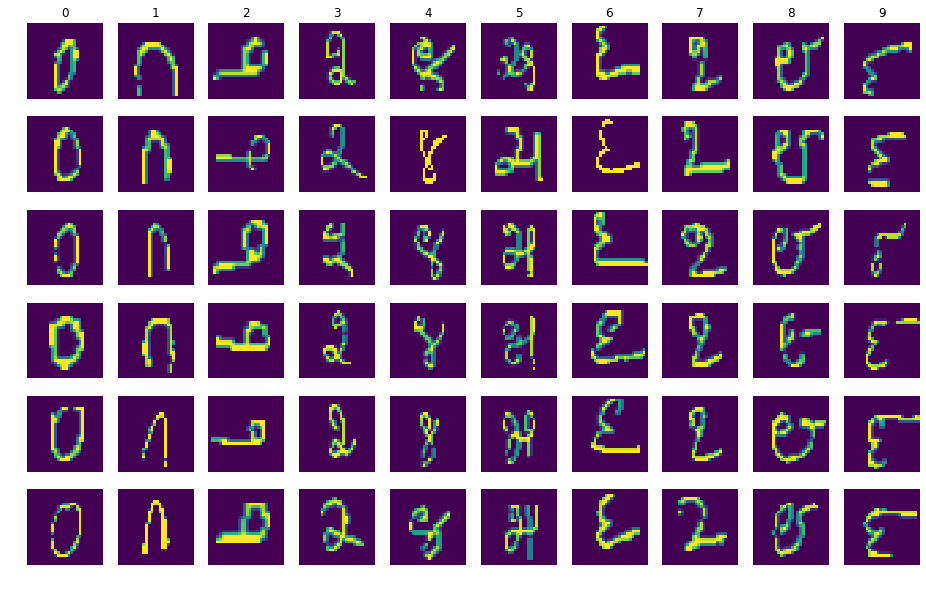

In [7]:
num_classes = len(classes)
samples_per_class = 6
plt.figure(0,figsize=(16,10))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(Plot_Y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].reshape((28,28)))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

**Data Augmentation**

In [8]:
datagen = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

**Build the model**

In [9]:
# BUILD CONVOLUTIONAL NEURAL NETWORKS
nets = 15
model = [0] *nets
for j in range(nets):
    model[j] = Sequential()

    model[j].add(Conv2D(32, kernel_size = 3, activation='relu', input_shape = (28, 28, 1)))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(32, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 3, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Conv2D(64, kernel_size = 5, strides=2, padding='same', activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Dropout(0.4))

    model[j].add(Conv2D(128, kernel_size = 4, activation='relu'))
    model[j].add(BatchNormalization())
    model[j].add(Flatten())
    model[j].add(Dropout(0.4))
    model[j].add(Dense(10, activation='softmax'))

    # COMPILE WITH ADAM OPTIMIZER AND CROSS ENTROPY COST
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

**Train the network**

In [10]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
# TRAIN NETWORKS
history = [0] * nets
epochs = 45
for j in range(nets):
    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(X_train, Y_train, test_size = 0.1)
    history[j] = model[j].fit_generator(datagen.flow(X_train2,Y_train2, batch_size=64),
        epochs = epochs, steps_per_epoch = X_train2.shape[0]//64,  
        validation_data = (X_val2,Y_val2), callbacks=[annealer], verbose=0)
    print("CNN {0:d}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
        j+1,epochs,max(history[j].history['acc']),max(history[j].history['val_acc']) ))

KeyError: 'acc'

In [11]:
##Initialise a matrix with rows = number of test images and columns = number of classifications (10)
predictions = np.zeros( (X_test.shape[0],10) ) 

##Loop through the different Neural networks to add together the predictions
for j in range(nets):
    predictions = predictions + model[j].predict(X_test)
    
test_labels = np.argmax(predictions, axis=1)

submission = pd.DataFrame(test_labels)
submission.index = test_id
submission.columns = ["label"]
submission.to_csv("submission.csv")